## Radial velocity fitting #fail

### Or, why I can't find planets by minimizing a cost function

I sat through the first week of Andrew Ng's machine learning Coursera videos and was super gung-ho to apply what I'd learned to a concrete example. In a future post I'll include more detail about the problem I'm trying to solve (exoplanet detection using radial velocity fitting); here I'll just explain what I tried to do and why it was the wrong approach.

The dataset I was working with was a set of stellar radial velocity measurements taken over a very long time baseline at spotty intervals. Here's an example:
![](/files/images/RV_raw_BD-103166.png)

This star obviously has some variation in its radial velocity (up to $\pm$60 m/s), caused by either a binary star companion, a planet, or surface activity. (In this case, the large amplitude and short timescale of the fluctuations suggests a planet is the culprit.) The goal is find a sinusoidal function of the form $A\sin(\omega t+c)$ which fits the data. The frequency $\omega$ is related to the orbital period $P$ of the potential planet by $\omega=2\pi/P$. If all goes well, we can find out what the orbital period is and 'phase-fold' the data to plot the radial velocity as a function of orbital phase, which makes it much more obvious that the variation is sinusoidal. Note that I generated the plots below using the orbital period that I looked up on Wikipedia. I never managed to fit the data correctly using the method below.

![](/files/images/phase_folded_BD-103166.png)

Note the precision on the period that was used to phase fold the data points--it goes to five decimal places. This isn't just a case of being overly careful in avoiding rounding errors. Look what happens if we are only accurate to 0.01-0.001 days in the orbital period:

![](/files/images/phase_folded_errors_BD-103166.png)

The figure above pretty much summarizes why my attempt to use a minimization algorithm to fit the data didn't work out. If you want to skip reading details below, minimization is *not* the way to solve this problem because the likelihood space has a lot of nooks and crannies and it's too hard for the algorithm to find its way to the true global minimum. Even if the algorithm had managed to make its way to within 0.01 days of the true period, the cost function gradient at that location in parameter space probably wouldn't have pointed us in the desired direction because we still get a bad fit to the data for periods 0.00777 days off from the true period.. Gradient descent works great for fitting functions that only have one minimum in the cost function space, but the sinusoidal function we're trying to model the data with doesn't fit this criterion.


### What I was trying to do:

Since I'd just finished learning about using the gradient descent algorithm to find the best-fitting parameters for some model, I thought I could use it to fit the parameters $A, \omega,$ and $c$ in sinusoidal radial velocity equation $v_r=A\sin(\omega t+c)$. 

The variations in a star's _measured_ radial velocity $v$ as a function of time $t$ can be fit by a sinusoidal hypothesis function:

$$ h(A,\omega,c) = A \sin(\omega t+c)$$

where $A$ is the amplitude of the sine fit (i.e. the maximum variation in the radial velocity), $\omega$ is the frequency of oscillation (related to the orbital period $T$ by $T=2\pi/\omega$ ), and $c$ is a phase offset.

We want to find the values of parameters $A, \omega, c$ which minimize the cost function 
$$ J(A,\omega,c) = \frac{1}{N} \sum\limits_{i=1}^N \left( \frac{h(A,\omega,c) - v_i}{\sigma_i} \right)^2 = \frac{1}{N} \sum\limits_{i=1}^N \left( \frac{ A \sin(\omega t_i+c) - v_i}{\sigma_i} \right)^2 $$

The cost function is a summation over all of our measure data points ${t_i, v_i, \sigma_i}$ where $\sigma_i$ is the uncertainty in the measured radial velocity.

By choosing an appropriate step size $\alpha$ stepping in parameters $\theta_j$ using the gradient descent algorithm

$$ \theta_j := \theta_j - \alpha \frac{\partial}{\partial\theta_j} J(\theta_0, \dots) $$

we should arrive at the set of parameters that best fits the data.

In this case, we are fitting the data with three parameters $\{\theta_0, \theta_1, \theta_2\}=\{A,\omega,c\}$. The partial derivatives of the cost function are thus


$$ \frac{\partial J}{\partial A} = \frac{1}{N} \sum\limits_{i=1}^N \frac{ \left(A \sin(\omega t_i+c) - v_i \right) \sin(\omega t_i +c)} {\sigma_i^2} $$

$$ \frac{\partial J}{\partial \omega} = \frac{1}{N}\sum\limits_{i=1}^N \frac{\left(A \sin(\omega t_i+c) - v_i \right) A \cos(\omega t_i+C) t_i}{\sigma_i^2} $$

$$ \frac{\partial J}{\partial c} = \frac{1}{N}\sum\limits_{i=1}^N \frac{\left(A \sin(\omega t_i+c) - v_i \right) A \cos(\omega t_i+C)}{\sigma_i^2} $$

I included the code I used as well as the test data file (available [here](BD-103166_KECK.vels)) in case you want to play around with it and find your own terrible fit to the data. 

Aside from the main problem (which I'll discuss in just a bit), there are other issues that cropped up when I tried to implement this algorithm that would also be problematic. A few that I could think of:

* Note that the expression for $\partial J/\partial \omega$ is of order $\mathcal{O}(A^2 t/\sigma_i^2)$. It has a factor of t in the summation that the other two expressions don't have. The value of $t_i$ in the summation can be quite large (upwards of thousands), which would make the step size in the $\omega$ direction very large unless compensated for by having a smaller $\alpha$. Since $\alpha$ is shared in the three expressions for the partial derivatives, I worry that the steps in $A$ and $c$ might not be large enough to explore the parameter space well.
* We have a good idea for what the minimum and maximum values of $A, \omega,$ and $c$ should be: $A$ must be around 60 m/s just from looking at the raw data, $\omega$ should correspond to a period of ~hours to days, and the phase $c$ must be between 0 and $2\pi$. I'm not sure how the algorithm should behave if a step in one direction runs into one of these minima/maxima. (The algorithm seems to like to instantly move to huge values of $\omega$ even they correspond to unphysically short orbital periods.)

In [21]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [22]:
star_ID = 'BD-103166'

# import data for one star
# columns: Julian date, velocity [m/s], sig_vel [m/s], 
# S_value, Halpha, median photons/pix, exposure time [s]
t, v, sig_v, sval, Halpha, phot_pix, exp_t = np.loadtxt('/files/data/'+star_ID+'_KECK.vels', unpack=True)

# subtract off starting observation date so that first data point is t=0
start_t = np.min(t)
t = t - start_t

# number of total data points
N = len(t)

# cost function J(A, w, c)
def J(A, w, c):
    sum = 0.
    for i in range(N):
        sum += (A * np.sin(w*t[i] + c) - v[i])**2 / sig_v[i]**2
    return sum/(2*N)

# partial derivative of J w.r.t. parameters A, w, c
def dJdA(A, w, c):
    sum = 0.
    for i in range(N):
        sum +=  (A * np.sin(w*t[i] + c) - v[i]) * np.sin(w*t[i]+c) / sig_v[i]**2
    return sum/N
def dJdw(A, w, c):
    sum = 0.
    for i in range(N):
        sum += (A * np.sin(w*t[i] + c) - v[i]) * A * np.cos(w*t[i]+c)* t[i] / sig_v[i]**2
    return sum/N
def dJdc(A, w, c):
    sum = 0.
    for i in range(N):
        sum += (A * np.sin(w*t[i] + c) - v[i]) * A * np.cos(w*t[i]+c) / sig_v[i]**2
    return sum/N    

# implement gradient descent algorithm
# will continue to take steps until change in deltaJ/J is < tol*J 
# or max number of steps exceeded

# starting guesses for A, w, c
A, w, c = 60., 2*np.pi/3.4877, 0.2
min_A , max_A = 10, 1000
min_w, max_w = 0., 1000
min_c, max_c = 0, 2*np.pi

# set bounds for 
Jval = J(A,w,c)

# alpha = step size for gradient descent
alpha = 0.001

tol = 1e-5
stepcount = 1
deltaJ_frac = 100      # initialize as large number so that while loop doesn't exit
maxSteps = 200000

# save deltaJ/J every X steps so we can keep track of how the algorithm is doing
save_interval = 20
nstep_arr, deltaJ_arr, J_arr= [],[],[]


# run until the change in J is sufficiently small (deltaJ/J < tolerance)
# or maximum number of steps reached and we cut it off for taking too long

while ( abs(deltaJ_frac)>abs(tol) and stepcount<maxSteps ):
    # temporary variables so that A,w,c are adjusted simultaneously
    temp_A = A - alpha * dJdA(A,w,c) 
    temp_w = w - alpha * dJdw(A,w,c)
    temp_c = c - alpha * dJdc(A,w,c)
    temp_J = Jval
    A = temp_A
    w = temp_w
    c = temp_c
    Jval = J(A,w,c)
    deltaJ = Jval-temp_J
    deltaJ_frac = deltaJ/Jval
    stepcount+=1

    if stepcount%save_interval==0:
        nstep_arr.append(stepcount)
        deltaJ_arr.append(abs(deltaJ_frac))
        J_arr.append(Jval)

print(stepcount,' steps taken')
print('Best fitting parameters: \n A=',A,'\n w=',w,'\n c=',c)


39462  steps taken
Best fitting parameters: 
 A= 2.87377820789 
 w= 8814.97480976 
 c= 1.71288080699


The output of the code above obviously doesn't fit the data. The amplitude is too low (A = 17 m/s, when it is clearly closer to 60 m/s) and the frequency is way too high. See the plot generated below:

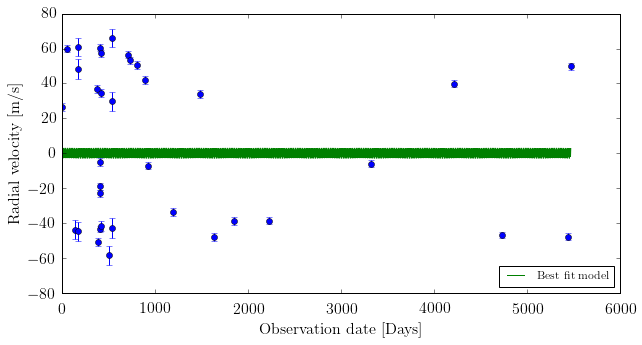

In [19]:
# plot best fitting function over data points

fig= plt.figure(figsize=(10,5))
ax=fig.add_subplot(111)
for item in ([ax.xaxis.label, ax.yaxis.label] + 
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(16)

t_arr = np.linspace(0,np.max(t),2000)
v_model = A * np.sin(w*t_arr+c)

ax.errorbar(t, v, yerr=sig_v, fmt='o')
ax.plot(t_arr, v_model, label='Best fit model')
ax.set_xlabel('Observation date [Days]')
ax.set_ylabel('Radial velocity [m/s]')
ax.legend(loc='lower right')
plt.show()

Just to show that I didn't completely mess up when coding up the algorithm, here's a check to make sure that it was finding its way into some minima of the cost function (obviously it never found the global minimum):

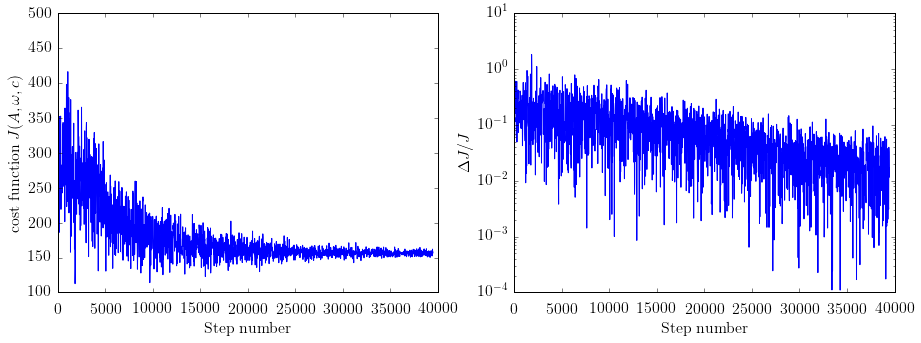

In [18]:
# plot change in cost function over number of steps
fig= plt.figure(figsize=(15,5))
ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)
for item in ([ax1.xaxis.label, ax1.yaxis.label] + 
             ax1.get_xticklabels() + ax1.get_yticklabels()):
    item.set_fontsize(16)
for item in ([ax2.xaxis.label, ax2.yaxis.label] + 
             ax2.get_xticklabels() + ax2.get_yticklabels()):
    item.set_fontsize(16)
ax2.set_yscale('log')
ax1.plot(nstep_arr, J_arr)
ax2.plot(nstep_arr, deltaJ_arr)
ax1.set_xlabel('Step number')
ax1.set_ylabel('cost function $J(A,\omega,c$)')
ax2.set_xlabel('Step number')
ax2.set_ylabel(r'$\Delta J/J$')
plt.show()

The cost function (left plot) does decrease as I loop over the algorithm, eventually bottoming out after ~10,000 steps. However, the output model doesn't fit the data well at all, meaning that the minimum that the algorithm found is just some local minimum that we got stuck in. 

### Moral of the story

This is a pretty good example of why it's important to stop and consider the problem at hand before blindly chugging ahead. In hindsight, radial velocity fitting is a textbook case of when to use a time series analysis. The next post should hopefully be an update where I actually succeed in picking out the exoplanet orbital periods.